# IMBALANCED CLASSIFICATION - Tutorial Lengkap

## Pengenalan

**Imbalanced Classification** adalah masalah klasifikasi dimana distribusi kelas dalam dataset tidak seimbang (skewed/biased).

### Contoh Kasus Real-World:
- **Fraud Detection**: 99% transaksi normal vs 1% fraud
- **Medical Diagnosis**: 95% pasien sehat vs 5% pasien sakit  
- **Churn Prediction**: 90% customer tetap vs 10% churn
- **Spam Detection**: 90% email normal vs 10% spam
- **Manufacturing Defects**: 99% produk bagus vs 1% defect

---

## Daftar Isi:

1. **Load & Explore Dataset**
2. **Baseline Model (Tanpa Handling)**
3. **Metode Resampling**
   - Random Oversampling
   - SMOTE (Synthetic Minority Over-sampling Technique)
   - Random Undersampling
   - SMOTEENN (Kombinasi)
4. **Class Weight Adjustment**
5. **Ensemble Learning**
   - Balanced Random Forest
   - Gradient Boosting
   - AdaBoost
   - Easy Ensemble
   - Voting Classifier
   - Stacking Classifier
6. **Metrics Evaluation**
7. **Perbandingan Semua Metode**
8. **Visualisasi**

---

## 1. Import Libraries

In [1]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (RandomForestClassifier, GradientBoostingClassifier,
                             AdaBoostClassifier, VotingClassifier, StackingClassifier)

# Metrics
from sklearn.metrics import (classification_report, confusion_matrix, 
                            precision_score, recall_score, f1_score,
                            average_precision_score, roc_auc_score, roc_curve, auc)

# Imbalanced-learn library
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
from imblearn.ensemble import BalancedRandomForestClassifier, EasyEnsembleClassifier
from imblearn.pipeline import Pipeline

# Settings
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("Set2")

print("Libraries imported successfully")

Libraries imported successfully


## Contoh Cepat: Dataset Sintetis Tidak Seimbang
Contoh ini membuat dataset buatan dengan proporsi kelas 94:6 lalu membandingkan baseline Logistic Regression, Logistic Regression + SMOTE, dan Balanced Random Forest. Kita pantau metrik yang relevan untuk kelas minoritas.

Total sampel: 5000
Mayoritas (kelas 0): 4678 sampel (93.56%)
Minoritas (kelas 1): 322 sampel (6.44%)


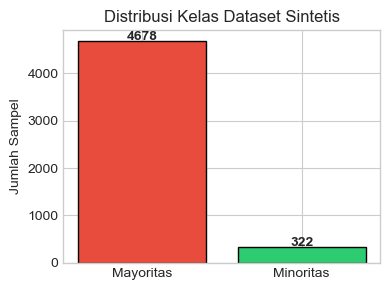

In [2]:
# Bangun dataset sintetis dengan ketidakseimbangan tajam
from sklearn.datasets import make_classification
from collections import Counter

X_syn, y_syn = make_classification(
    n_samples=5000,
    n_features=20,
    n_informative=5,
    n_redundant=2,
    n_clusters_per_class=1,
    weights=[0.94, 0.06],
    class_sep=1.6,
    flip_y=0.01,
    random_state=42
 )

class_counts = Counter(y_syn)
total_samples = len(y_syn)
print(f"Total sampel: {total_samples}")
for label, count in class_counts.items():
    proportion = count / total_samples * 100
    desc = 'Mayoritas (kelas 0)' if label == 0 else 'Minoritas (kelas 1)'
    print(f"{desc}: {count} sampel ({proportion:.2f}%)")

fig, ax = plt.subplots(figsize=(4, 3))
ax.bar(class_counts.keys(), class_counts.values(), color=['#e74c3c', '#2ecc71'], edgecolor='black')
ax.set_xticks([0, 1])
ax.set_xticklabels(['Mayoritas', 'Minoritas'])
ax.set_ylabel('Jumlah Sampel')
ax.set_title('Distribusi Kelas Dataset Sintetis')
for idx, val in enumerate(class_counts.values()):
    ax.text(idx, val + 30, f"{val}", ha='center', fontweight='bold')
plt.tight_layout()
plt.show()

In [3]:
# Bandingkan baseline vs teknik penyeimbangan
metrics_snapshot = []
X_train_syn, X_test_syn, y_train_syn, y_test_syn = train_test_split(
    X_syn, y_syn, test_size=0.3, stratify=y_syn, random_state=42
 )

def evaluate_model(name, estimator):
    estimator.fit(X_train_syn, y_train_syn)
    y_pred = estimator.predict(X_test_syn)
    if hasattr(estimator, "predict_proba"):
        y_score = estimator.predict_proba(X_test_syn)[:, 1]
    else:
        raw_score = estimator.decision_function(X_test_syn)
        y_score = (raw_score - raw_score.min()) / (raw_score.max() - raw_score.min() + 1e-9)
    metrics_snapshot.append({
        'Model': name,
        'Precision': precision_score(y_test_syn, y_pred),
        'Recall': recall_score(y_test_syn, y_pred),
        'F1-Score': f1_score(y_test_syn, y_pred),
        'ROC-AUC': roc_auc_score(y_test_syn, y_score),
        'PR-AUC': average_precision_score(y_test_syn, y_score)
    })
    print(f"{name}\n" + "-" * 60)
    print(classification_report(y_test_syn, y_pred, target_names=['Mayoritas', 'Minoritas']))

baseline_lr = LogisticRegression(max_iter=1000, random_state=42)
evaluate_model('Baseline Logistic Regression', baseline_lr)

smote_lr = Pipeline([
    ('smote', SMOTE(random_state=42)),
    ('model', LogisticRegression(max_iter=1000, random_state=42))
])
evaluate_model('Logistic Regression + SMOTE', smote_lr)

brf = BalancedRandomForestClassifier(n_estimators=200, random_state=42, n_jobs=-1)
evaluate_model('Balanced Random Forest', brf)

Baseline Logistic Regression
------------------------------------------------------------
              precision    recall  f1-score   support

   Mayoritas       0.99      1.00      1.00      1403
   Minoritas       1.00      0.91      0.95        97

    accuracy                           0.99      1500
   macro avg       1.00      0.95      0.97      1500
weighted avg       0.99      0.99      0.99      1500

Logistic Regression + SMOTE
------------------------------------------------------------
              precision    recall  f1-score   support

   Mayoritas       0.99      0.99      0.99      1403
   Minoritas       0.88      0.91      0.89        97

    accuracy                           0.99      1500
   macro avg       0.94      0.95      0.94      1500
weighted avg       0.99      0.99      0.99      1500

Logistic Regression + SMOTE
------------------------------------------------------------
              precision    recall  f1-score   support

   Mayoritas       0.99

  File "c:\Users\AUDIT-PC\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


Balanced Random Forest
------------------------------------------------------------
              precision    recall  f1-score   support

   Mayoritas       0.99      0.99      0.99      1403
   Minoritas       0.84      0.88      0.86        97

    accuracy                           0.98      1500
   macro avg       0.92      0.93      0.92      1500
weighted avg       0.98      0.98      0.98      1500



In [4]:
# Ringkas metrik utama agar mudah dibandingkan
synthetic_results_df = pd.DataFrame(metrics_snapshot).sort_values('F1-Score', ascending=False)
print("Perbandingan Metrik pada Dataset Sintetis")
print("=" * 70)
print(synthetic_results_df.to_string(index=False))
print("=" * 70)

Perbandingan Metrik pada Dataset Sintetis
                       Model  Precision   Recall  F1-Score  ROC-AUC   PR-AUC
Baseline Logistic Regression   1.000000 0.907216  0.951351 0.946595 0.921854
 Logistic Regression + SMOTE   0.880000 0.907216  0.893401 0.946712 0.923041
      Balanced Random Forest   0.841584 0.876289  0.858586 0.952208 0.911964


## 2. Load & Explore Dataset

Kita akan menggunakan **Titanic dataset** dari seaborn - dataset klasik untuk prediksi survival dengan class imbalance natural.

Dataset Shape: (891, 15)

Column Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 15 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   survived     891 non-null    int64   
 1   pclass       891 non-null    int64   
 2   sex          891 non-null    object  
 3   age          714 non-null    float64 
 4   sibsp        891 non-null    int64   
 5   parch        891 non-null    int64   
 6   fare         891 non-null    float64 
 7   embarked     889 non-null    object  
 8   class        891 non-null    category
 9   who          891 non-null    object  
 10  adult_male   891 non-null    bool    
 11  deck         203 non-null    category
 12  embark_town  889 non-null    object  
 13  alive        891 non-null    object  
 14  alone        891 non-null    bool    
dtypes: bool(2), category(2), float64(2), int64(4), object(5)
memory usage: 80.7+ KB
None

First 5 rows:
   survived  pclass 

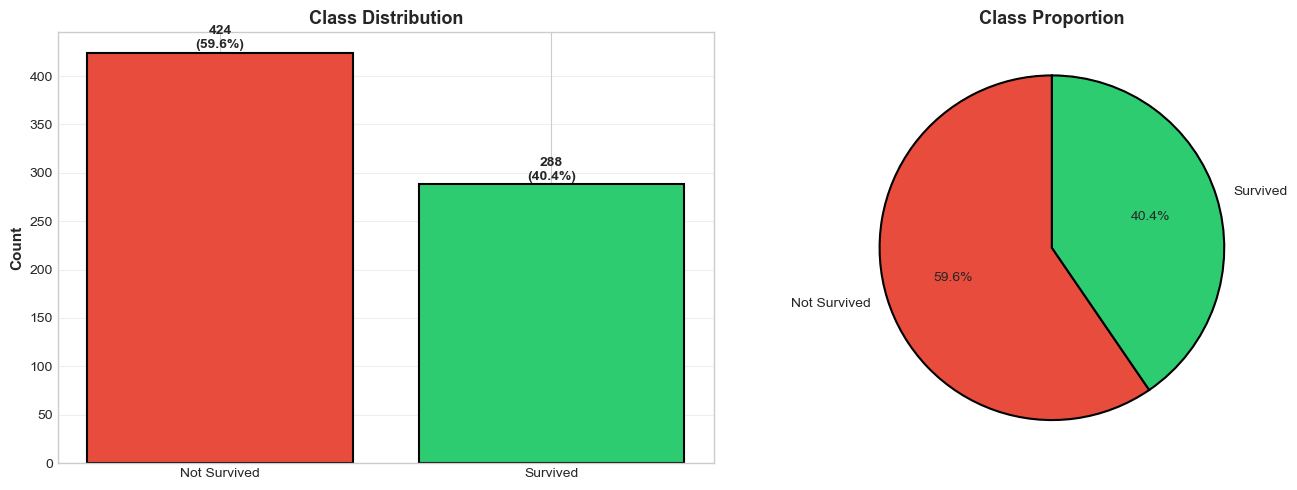

In [5]:
# Load Titanic dataset
df = sns.load_dataset('titanic')

print("Dataset Shape:", df.shape)
print("\nColumn Info:")
print(df.info())
print("\nFirst 5 rows:")
print(df.head())

# Data preprocessing
# Select features and target
features = ['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare', 'embarked', 'alone']
target = 'survived'

# Drop rows with missing values in selected columns
df_clean = df[features + [target]].dropna()

# Encode categorical variables
le_sex = LabelEncoder()
le_embarked = LabelEncoder()
df_clean['sex'] = le_sex.fit_transform(df_clean['sex'])
df_clean['embarked'] = le_embarked.fit_transform(df_clean['embarked'])
df_clean['alone'] = df_clean['alone'].astype(int)

# Separate features and target
X = df_clean[features].values
y = df_clean[target].values

print("\n" + "="*70)
print("CLASS DISTRIBUTION")
print("="*70)
unique, counts = np.unique(y, return_counts=True)
for cls, cnt in zip(unique, counts):
    percentage = (cnt/len(y)*100)
    print(f"Class {cls} ({'Not Survived' if cls==0 else 'Survived'}): {cnt:3d} ({percentage:5.2f}%)")

imbalance_ratio = max(counts) / min(counts)
print(f"\nImbalance Ratio: {imbalance_ratio:.2f}:1")

# Visualize class distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar plot
axes[0].bar(['Not Survived', 'Survived'], counts, color=['#e74c3c', '#2ecc71'], 
            edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('Count', fontsize=11, fontweight='bold')
axes[0].set_title('Class Distribution', fontsize=13, fontweight='bold')
axes[0].grid(axis='y', alpha=0.3)
for i, cnt in enumerate(counts):
    axes[0].text(i, cnt + 5, f'{cnt}\n({cnt/len(y)*100:.1f}%)', 
                ha='center', fontweight='bold')

# Pie chart
axes[1].pie(counts, labels=['Not Survived', 'Survived'], autopct='%1.1f%%',
           colors=['#e74c3c', '#2ecc71'], startangle=90, 
           wedgeprops={'edgecolor': 'black', 'linewidth': 1.5})
axes[1].set_title('Class Proportion', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.show()
print("="*70)

### Split Data & Preprocessing

In [6]:
# Split data dengan stratify untuk mempertahankan proporsi kelas
X_train, X_test, y_train, y_test = train_test_split(
    X, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y
)

# Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Data Split Complete")
print(f"Training set: {X_train.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")
print("\nTraining set class distribution:")
unique_train, counts_train = np.unique(y_train, return_counts=True)
for cls, cnt in zip(unique_train, counts_train):
    print(f"  Class {cls}: {cnt} ({cnt/len(y_train)*100:.2f}%)")

Data Split Complete
Training set: 569 samples
Test set: 143 samples

Training set class distribution:
  Class 0: 339 (59.58%)
  Class 1: 230 (40.42%)


## 3. Baseline Model (Tanpa Handling Imbalance)

Mari kita coba model baseline **tanpa** menangani imbalance.

**Catatan:** Mengapa TIDAK pakai Accuracy untuk Imbalanced Data?
- Jika data 60% kelas 0 dan 40% kelas 1, model yang selalu prediksi kelas 0 akan dapat accuracy 60%!
- Model ini TIDAK berguna karena tidak bisa mendeteksi kelas minoritas (yang biasanya lebih penting)

In [7]:
# Train baseline model
baseline_model = LogisticRegression(random_state=42, max_iter=1000)
baseline_model.fit(X_train_scaled, y_train)
y_pred_baseline = baseline_model.predict(X_test_scaled)
y_pred_proba_baseline = baseline_model.predict_proba(X_test_scaled)[:, 1]

print("BASELINE MODEL - Logistic Regression")
print("="*70)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_baseline)
print("\nConfusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_baseline, 
                          target_names=['Not Survived', 'Survived']))

# Metrics
baseline_f1 = f1_score(y_test, y_pred_baseline)
baseline_recall = recall_score(y_test, y_pred_baseline)
baseline_precision = precision_score(y_test, y_pred_baseline)
baseline_roc_auc = roc_auc_score(y_test, y_pred_proba_baseline)

print("\nKey Metrics:")
print(f"Precision: {baseline_precision:.4f}")
print(f"Recall:    {baseline_recall:.4f}")
print(f"F1-Score:  {baseline_f1:.4f}")
print(f"ROC-AUC:   {baseline_roc_auc:.4f}")
print("="*70)

BASELINE MODEL - Logistic Regression

Confusion Matrix:
[[71 14]
 [15 43]]

Classification Report:
              precision    recall  f1-score   support

Not Survived       0.83      0.84      0.83        85
    Survived       0.75      0.74      0.75        58

    accuracy                           0.80       143
   macro avg       0.79      0.79      0.79       143
weighted avg       0.80      0.80      0.80       143


Key Metrics:
Precision: 0.7544
Recall:    0.7414
F1-Score:  0.7478
ROC-AUC:   0.8470


## 4. Metode Resampling

### Penjelasan Resampling:

1. **Oversampling**: Menambah jumlah sampel kelas minoritas
   - Random Oversampling: Duplikasi sampel minoritas
   - **SMOTE**: Membuat sampel sintetis baru (lebih baik!)

2. **Undersampling**: Mengurangi jumlah sampel kelas mayoritas
   - Random Undersampling: Hapus sampel mayoritas
   - **Risiko**: Kehilangan informasi

3. **Kombinasi**: Gabungan oversampling & undersampling
   - SMOTEENN: SMOTE + Edited Nearest Neighbors

### 4.1 SMOTE (Synthetic Minority Over-sampling Technique)

**SMOTE** membuat **sampel sintetis baru** untuk kelas minoritas, bukan sekedar duplikasi.

**Cara kerja:**
1. Pilih sampel minoritas secara random
2. Cari k-nearest neighbors
3. Buat sampel baru di antara sampel dan tetangganya
4. Hasil: Data lebih beragam

In [8]:
# Apply SMOTE
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

print("SMOTE - Synthetic Minority Over-sampling")
print("="*70)
print("\nBefore SMOTE:")
print(f"Total: {len(y_train)} samples")
unique_before, counts_before = np.unique(y_train, return_counts=True)
for cls, cnt in zip(unique_before, counts_before):
    print(f"  Class {cls}: {cnt} ({cnt/len(y_train)*100:.2f}%)")

print("\nAfter SMOTE:")
print(f"Total: {len(y_train_smote)} samples")
unique_after, counts_after = np.unique(y_train_smote, return_counts=True)
for cls, cnt in zip(unique_after, counts_after):
    print(f"  Class {cls}: {cnt} ({cnt/len(y_train_smote)*100:.2f}%)")

print("\nClasses are now balanced!")

# Train model with SMOTE data
model_smote = LogisticRegression(random_state=42, max_iter=1000)
model_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = model_smote.predict(X_test_scaled)
y_pred_proba_smote = model_smote.predict_proba(X_test_scaled)[:, 1]

print("\nClassification Report (SMOTE):")
print(classification_report(y_test, y_pred_smote, target_names=['Not Survived', 'Survived']))

f1_smote = f1_score(y_test, y_pred_smote)
recall_smote = recall_score(y_test, y_pred_smote)
roc_auc_smote = roc_auc_score(y_test, y_pred_proba_smote)

print("Metrics Improvement:")
print(f"F1-Score:  {baseline_f1:.4f} -> {f1_smote:.4f} ({(f1_smote-baseline_f1)/baseline_f1*100:+.1f}%)")
print(f"Recall:    {baseline_recall:.4f} -> {recall_smote:.4f} ({(recall_smote-baseline_recall)/baseline_recall*100:+.1f}%)")
print(f"ROC-AUC:   {baseline_roc_auc:.4f} -> {roc_auc_smote:.4f} ({(roc_auc_smote-baseline_roc_auc)/baseline_roc_auc*100:+.1f}%)")
print("="*70)

SMOTE - Synthetic Minority Over-sampling

Before SMOTE:
Total: 569 samples
  Class 0: 339 (59.58%)
  Class 1: 230 (40.42%)

After SMOTE:
Total: 678 samples
  Class 0: 339 (50.00%)
  Class 1: 339 (50.00%)

Classes are now balanced!

Classification Report (SMOTE):
              precision    recall  f1-score   support

Not Survived       0.85      0.80      0.82        85
    Survived       0.73      0.79      0.76        58

    accuracy                           0.80       143
   macro avg       0.79      0.80      0.79       143
weighted avg       0.80      0.80      0.80       143

Metrics Improvement:
F1-Score:  0.7478 -> 0.7603 (+1.7%)
Recall:    0.7414 -> 0.7931 (+7.0%)
ROC-AUC:   0.8470 -> 0.8445 (-0.3%)


### 4.2 Testing Berbagai Metode Resampling

In [9]:
# Store results
results = {
    'Method': ['Baseline'],
    'F1-Score': [baseline_f1],
    'Recall': [baseline_recall],
    'Precision': [baseline_precision],
    'ROC-AUC': [baseline_roc_auc]
}

# Add SMOTE results
results['Method'].append('SMOTE')
results['F1-Score'].append(f1_smote)
results['Recall'].append(recall_smote)
results['Precision'].append(precision_score(y_test, y_pred_smote))
results['ROC-AUC'].append(roc_auc_smote)

print("Testing Multiple Resampling Methods...")
print("="*70)

# 1. Random Oversampling
ros = RandomOverSampler(random_state=42)
X_ros, y_ros = ros.fit_resample(X_train_scaled, y_train)
model_ros = LogisticRegression(random_state=42, max_iter=1000)
model_ros.fit(X_ros, y_ros)
y_pred_ros = model_ros.predict(X_test_scaled)
y_proba_ros = model_ros.predict_proba(X_test_scaled)[:, 1]

results['Method'].append('Random Oversampling')
results['F1-Score'].append(f1_score(y_test, y_pred_ros))
results['Recall'].append(recall_score(y_test, y_pred_ros))
results['Precision'].append(precision_score(y_test, y_pred_ros))
results['ROC-AUC'].append(roc_auc_score(y_test, y_proba_ros))

# 2. Random Undersampling
rus = RandomUnderSampler(random_state=42)
X_rus, y_rus = rus.fit_resample(X_train_scaled, y_train)
model_rus = LogisticRegression(random_state=42, max_iter=1000)
model_rus.fit(X_rus, y_rus)
y_pred_rus = model_rus.predict(X_test_scaled)
y_proba_rus = model_rus.predict_proba(X_test_scaled)[:, 1]

results['Method'].append('Random Undersampling')
results['F1-Score'].append(f1_score(y_test, y_pred_rus))
results['Recall'].append(recall_score(y_test, y_pred_rus))
results['Precision'].append(precision_score(y_test, y_pred_rus))
results['ROC-AUC'].append(roc_auc_score(y_test, y_proba_rus))

# 3. SMOTEENN
smoteenn = SMOTEENN(random_state=42)
X_smoteenn, y_smoteenn = smoteenn.fit_resample(X_train_scaled, y_train)
model_smoteenn = LogisticRegression(random_state=42, max_iter=1000)
model_smoteenn.fit(X_smoteenn, y_smoteenn)
y_pred_smoteenn = model_smoteenn.predict(X_test_scaled)
y_proba_smoteenn = model_smoteenn.predict_proba(X_test_scaled)[:, 1]

results['Method'].append('SMOTEENN')
results['F1-Score'].append(f1_score(y_test, y_pred_smoteenn))
results['Recall'].append(recall_score(y_test, y_pred_smoteenn))
results['Precision'].append(precision_score(y_test, y_pred_smoteenn))
results['ROC-AUC'].append(roc_auc_score(y_test, y_proba_smoteenn))

# 4. Class Weight
model_weighted = LogisticRegression(class_weight='balanced', random_state=42, max_iter=1000)
model_weighted.fit(X_train_scaled, y_train)
y_pred_weighted = model_weighted.predict(X_test_scaled)
y_proba_weighted = model_weighted.predict_proba(X_test_scaled)[:, 1]

results['Method'].append('Class Weight')
results['F1-Score'].append(f1_score(y_test, y_pred_weighted))
results['Recall'].append(recall_score(y_test, y_pred_weighted))
results['Precision'].append(precision_score(y_test, y_pred_weighted))
results['ROC-AUC'].append(roc_auc_score(y_test, y_proba_weighted))

print("Resampling methods tested successfully")
print("="*70)

Testing Multiple Resampling Methods...
Resampling methods tested successfully


## 5. ENSEMBLE LEARNING

### Apa itu Ensemble Learning?

**Ensemble Learning** = Menggabungkan beberapa model untuk hasil yang lebih baik.

### Jenis-jenis Ensemble:

1. **Bagging** (Bootstrap Aggregating)
   - Random Forest
   - Mengurangi variance (overfitting)
   - Training parallel

2. **Boosting**
   - AdaBoost, Gradient Boosting, XGBoost
   - Fokus pada sampel yang salah
   - Training sequential
   - Mengurangi bias

3. **Stacking**
   - Gabungkan berbagai model
   - Meta-learner untuk final prediction

4. **Voting**
   - Majority voting (hard)
   - Probability averaging (soft)

### 5.1 Testing Ensemble Methods

In [10]:
print("Testing Ensemble Methods...")
print("="*70)

# 1. Balanced Random Forest
print("Testing Balanced Random Forest...")
brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
brf.fit(X_train_scaled, y_train)
y_pred_brf = brf.predict(X_test_scaled)
y_proba_brf = brf.predict_proba(X_test_scaled)[:, 1]

results['Method'].append('Balanced Random Forest')
results['F1-Score'].append(f1_score(y_test, y_pred_brf))
results['Recall'].append(recall_score(y_test, y_pred_brf))
results['Precision'].append(precision_score(y_test, y_pred_brf))
results['ROC-AUC'].append(roc_auc_score(y_test, y_proba_brf))

# 2. Gradient Boosting
print("Testing Gradient Boosting...")
gb = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb.fit(X_train_smote, y_train_smote)
y_pred_gb = gb.predict(X_test_scaled)
y_proba_gb = gb.predict_proba(X_test_scaled)[:, 1]

results['Method'].append('Gradient Boosting')
results['F1-Score'].append(f1_score(y_test, y_pred_gb))
results['Recall'].append(recall_score(y_test, y_pred_gb))
results['Precision'].append(precision_score(y_test, y_pred_gb))
results['ROC-AUC'].append(roc_auc_score(y_test, y_proba_gb))

# 3. AdaBoost
print("Testing AdaBoost...")
ada = AdaBoostClassifier(n_estimators=100, learning_rate=1.0, random_state=42)
ada.fit(X_train_smote, y_train_smote)
y_pred_ada = ada.predict(X_test_scaled)
y_proba_ada = ada.predict_proba(X_test_scaled)[:, 1]

results['Method'].append('AdaBoost')
results['F1-Score'].append(f1_score(y_test, y_pred_ada))
results['Recall'].append(recall_score(y_test, y_pred_ada))
results['Precision'].append(precision_score(y_test, y_pred_ada))
results['ROC-AUC'].append(roc_auc_score(y_test, y_proba_ada))

# 4. Easy Ensemble
print("Testing Easy Ensemble...")
eec = EasyEnsembleClassifier(n_estimators=10, random_state=42, n_jobs=-1)
eec.fit(X_train_scaled, y_train)
y_pred_eec = eec.predict(X_test_scaled)
y_proba_eec = eec.predict_proba(X_test_scaled)[:, 1]

results['Method'].append('Easy Ensemble')
results['F1-Score'].append(f1_score(y_test, y_pred_eec))
results['Recall'].append(recall_score(y_test, y_pred_eec))
results['Precision'].append(precision_score(y_test, y_pred_eec))
results['ROC-AUC'].append(roc_auc_score(y_test, y_proba_eec))

# 5. Voting Classifier
print("Testing Voting Classifier...")
voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(class_weight='balanced', max_iter=1000)),
        ('rf', RandomForestClassifier(class_weight='balanced', n_estimators=50, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42))
    ],
    voting='soft'
)
voting_clf.fit(X_train_smote, y_train_smote)
y_pred_voting = voting_clf.predict(X_test_scaled)
y_proba_voting = voting_clf.predict_proba(X_test_scaled)[:, 1]

results['Method'].append('Voting Classifier')
results['F1-Score'].append(f1_score(y_test, y_pred_voting))
results['Recall'].append(recall_score(y_test, y_pred_voting))
results['Precision'].append(precision_score(y_test, y_pred_voting))
results['ROC-AUC'].append(roc_auc_score(y_test, y_proba_voting))

# 6. Stacking Classifier
print("Testing Stacking Classifier...")
stacking_clf = StackingClassifier(
    estimators=[
        ('lr', LogisticRegression(class_weight='balanced', max_iter=1000)),
        ('rf', RandomForestClassifier(class_weight='balanced', n_estimators=50, random_state=42)),
        ('gb', GradientBoostingClassifier(n_estimators=50, random_state=42))
    ],
    final_estimator=LogisticRegression(class_weight='balanced', max_iter=1000)
)
stacking_clf.fit(X_train_smote, y_train_smote)
y_pred_stacking = stacking_clf.predict(X_test_scaled)
y_proba_stacking = stacking_clf.predict_proba(X_test_scaled)[:, 1]

results['Method'].append('Stacking Classifier')
results['F1-Score'].append(f1_score(y_test, y_pred_stacking))
results['Recall'].append(recall_score(y_test, y_pred_stacking))
results['Precision'].append(precision_score(y_test, y_pred_stacking))
results['ROC-AUC'].append(roc_auc_score(y_test, y_proba_stacking))

print("\nAll ensemble methods tested successfully")
print("="*70)

Testing Ensemble Methods...
Testing Balanced Random Forest...
Testing Gradient Boosting...
Testing AdaBoost...
Testing Gradient Boosting...
Testing AdaBoost...
Testing Easy Ensemble...
Testing Easy Ensemble...
Testing Voting Classifier...
Testing Stacking Classifier...
Testing Voting Classifier...
Testing Stacking Classifier...

All ensemble methods tested successfully

All ensemble methods tested successfully


## 6. Comparison and Visualization

In [11]:
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('F1-Score', ascending=False)

print("Performance Comparison of All Methods")
print("="*70)
print(results_df.to_string(index=False))
print("="*70)

Performance Comparison of All Methods
                Method  F1-Score   Recall  Precision  ROC-AUC
              AdaBoost  0.768000 0.827586   0.716418 0.847059
                 SMOTE  0.760331 0.793103   0.730159 0.844523
          Class Weight  0.758065 0.810345   0.712121 0.848174
   Random Oversampling  0.758065 0.810345   0.712121 0.843915
     Gradient Boosting  0.756303 0.775862   0.737705 0.868661
  Random Undersampling  0.752000 0.810345   0.701493 0.849189
   Stacking Classifier  0.750000 0.775862   0.725806 0.870081
              Baseline  0.747826 0.741379   0.754386 0.846957
     Voting Classifier  0.743802 0.775862   0.714286 0.874341
              SMOTEENN  0.740157 0.810345   0.681159 0.834584
         Easy Ensemble  0.738462 0.827586   0.666667 0.854564
Balanced Random Forest  0.720000 0.775862   0.671642 0.859635


### 6.1 Visualize Performance Metrics

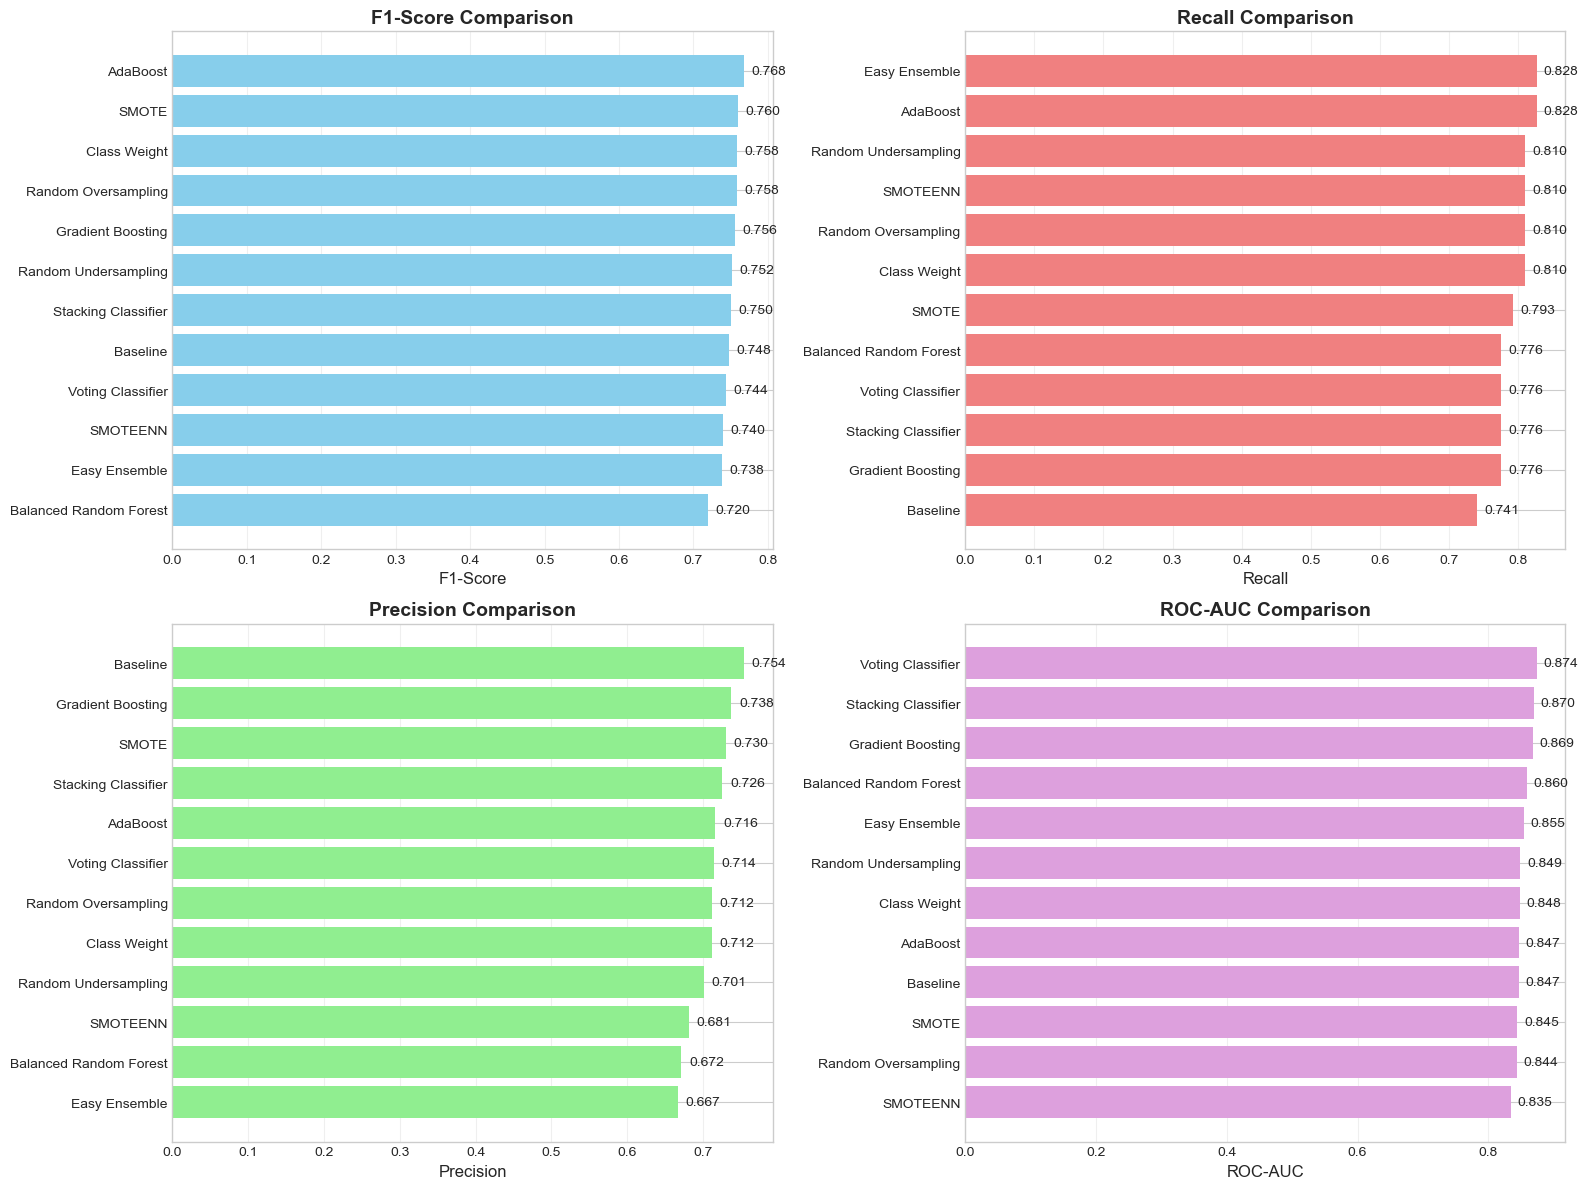

In [12]:
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

metrics = ['F1-Score', 'Recall', 'Precision', 'ROC-AUC']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'plum']

for idx, (metric, color) in enumerate(zip(metrics, colors)):
    ax = axes[idx // 2, idx % 2]
    results_df_sorted = results_df.sort_values(metric, ascending=True)
    ax.barh(results_df_sorted['Method'], results_df_sorted[metric], color=color)
    ax.set_xlabel(metric, fontsize=12)
    ax.set_title(f'{metric} Comparison', fontsize=14, fontweight='bold')
    ax.grid(axis='x', alpha=0.3)
    
    for i, v in enumerate(results_df_sorted[metric]):
        ax.text(v + 0.01, i, f'{v:.3f}', va='center', fontsize=10)

plt.tight_layout()
plt.show()

## 7. Understanding Metrics

When dealing with imbalanced classification, it's essential to use appropriate metrics:

### Key Metrics:
- **Precision**: Of all predicted positives, how many were actually positive? Important when false positives are costly.
- **Recall (Sensitivity)**: Of all actual positives, how many did we correctly identify? Important when false negatives are costly.
- **F1-Score**: Harmonic mean of precision and recall. Useful when you need a balance between the two.
- **ROC-AUC**: Measures the model's ability to distinguish between classes across all thresholds.

### Why Not Accuracy?
In imbalanced datasets, accuracy can be misleading. For example, if only 5% of cases are positive, a model that always predicts negative achieves 95% accuracy but is useless for identifying the minority class.

## 8. Conclusions

### Key Takeaways:

1. **Baseline models often struggle** with imbalanced data, showing high accuracy but poor recall for minority class
2. **Resampling techniques** like SMOTE, Random Over/Undersampling can significantly improve minority class detection
3. **Class weight adjustment** is a simple yet effective approach that doesn't require generating synthetic data
4. **Ensemble methods** often provide the best performance by combining multiple models
5. **Metric selection matters**: Use F1-Score, Recall, and ROC-AUC instead of accuracy for imbalanced problems
6. **No one-size-fits-all solution**: The best method depends on your specific dataset and business requirements

### Recommended Approach:
1. Start with baseline model to understand the problem
2. Try simple solutions first (class weights)
3. Experiment with resampling techniques (SMOTE)
4. Test ensemble methods for potential performance gains
5. Choose the method that best balances your precision/recall requirements

In [14]:
print("="*70)
print("TASK 3: IMBALANCED CLASSIFICATION - COMPLETED")
print("="*70)
print("\nDataset: Titanic (Seaborn)")
print(f"Methods tested: {len(results_df)}")
print(f"\nBest F1-Score: {results_df['F1-Score'].max():.4f}")
print(f"Best method: {results_df.loc[results_df['F1-Score'].idxmax(), 'Method']}")
print("="*70)

TASK 3: IMBALANCED CLASSIFICATION - COMPLETED

Dataset: Titanic (Seaborn)
Methods tested: 12

Best F1-Score: 0.7680
Best method: AdaBoost
